In [1]:
"""
    Import package
"""
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import time
import pandas
from torchsummary import summary
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
"""
    Read Image
"""
def readfile(path, label=None, imgRow=256, imgCol=256, datasize=10000):
    # label 是 csv file 在 ./ 下的名稱，有提供則回傳 y
    image_dir = sorted(os.listdir(path))
    i = 0
    count = 0
    eachFolder = datasize // 1000 #so each folder 10 or 100 images
    x = np.zeros((datasize, imgRow, imgCol, 1), dtype=np.uint8)
    y = np.zeros((datasize, imgRow, imgCol, 2), dtype=np.uint8)
    
    
    for folders in tqdm(image_dir):
        imgPath = os.path.join(path, folders)
        for file in os.listdir(imgPath):
            img = cv2.imread(os.path.join(imgPath, file))
            #plt.imshow(img)
            #plt.show()
            #return
            
            # 0≤L≤100 , −127≤a≤127, −127≤b≤127
            # 8-bit images: L←L∗255/100,a←a+128,b←b+128
            img = cv2.resize(img,(imgCol, imgRow))
            lab_image = cv2.cvtColor(img, cv2.COLOR_BGR2LAB) 
            l_channel, a_channel, b_channel = cv2.split(lab_image)
            x[i, :, :, 0] = l_channel # (x, y)
            y[i, :, :, 0] = a_channel
            y[i, :, :, 1] = b_channel
            i += 1
            count += 1
            if(count == eachFolder):
                count = 0
                break
    return x, y
    
def valAndTest(path, label=None, imgRow=256, imgCol=256, datasize=2000):
    # label 是 csv file 在 ./ 下的名稱，有提供則回傳 y
    image_dir = sorted(os.listdir(path))
    i = 0
    j = 0
    count = 0
    eachFolder = datasize // 1000 #so each folder 10 or 100 images
    xVal = np.zeros((datasize, imgRow, imgCol, 1), dtype=np.uint8)
    yVal = np.zeros((datasize, imgRow, imgCol, 2), dtype=np.uint8)
    xTest= np.zeros((datasize, imgRow, imgCol, 1), dtype=np.uint8)
    yTest= np.zeros((datasize, imgRow, imgCol, 2), dtype=np.uint8)
    
    for file in image_dir:
        img = cv2.imread(os.path.join(path, file))
        img = cv2.resize(img,(imgCol, imgRow))
        lab_image = cv2.cvtColor(img, cv2.COLOR_BGR2LAB) 
        l_channel, a_channel, b_channel = cv2.split(lab_image)
        
        if(count < datasize): # val
            xVal[i, :, :, 0]    = l_channel
            yVal[i, :, :, 0] = a_channel
            yVal[i, :, :, 1] = b_channel
            i += 1
        else: # test
            xTest[j, :, :, 0]    = l_channel
            yTest[j, :, :, 0] = a_channel
            yTest[j, :, :, 1] = b_channel
            j += 1
        count += 1
        
        if(count == datasize*2):
            break
    
            
    return xVal, yVal, xTest, yTest


In [3]:

#分別將 training set、validation set、testing set 用 readfile 函式讀進來
workspace_dir = r"C:\Users\USER\Desktop\VScode\ILSVRC\Data\CLS-LOC"
print("Reading data")
train_x, train_y = readfile(os.path.join(workspace_dir, "train"), "train", imgRow=256, imgCol=256, datasize=100000)
print("Size of training data = {}".format(len(train_x)))

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Reading data


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:51<00:00,  1.69it/s]


Size of training data = 100000
Size of validation data = 5000
Size of testing data = 5000


In [ ]:
L = train_x[101]
realAB = train_y[101]
realImg = (np.concatenate((L, realAB), axis=2)).astype(np.uint8)
# opencv 用 datatype 判斷圖片
realImg = cv2.cvtColor(realImg, cv2.COLOR_LAB2RGB)
plt.imshow(realImg)
plt.show()

L = train_x[99000]
realAB = train_y[99000]
realImg = (np.concatenate((L, realAB), axis=2)).astype(np.uint8)
# opencv 用 datatype 判斷圖片
realImg = cv2.cvtColor(realImg, cv2.COLOR_LAB2RGB)
plt.imshow(realImg)
plt.show()

In [3]:
workspace_dir = r"C:\Users\USER\Desktop\VScode\ILSVRC\Data\CLS-LOC"
val_x, val_y, test_x, test_y = valAndTest(os.path.join(workspace_dir, "val"), "dev", imgRow=256, imgCol=256, datasize=5000)
print("Size of validation data = {}".format(len(val_x)))
print("Size of testing data = {}".format(len(test_x)))

Size of validation data = 5000
Size of testing data = 5000


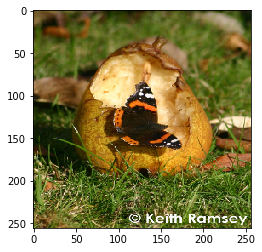

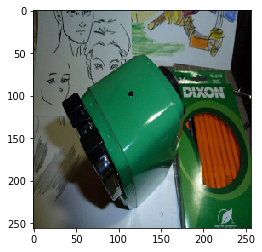

In [4]:
L = val_x[4999]
realAB = val_y[4999]
realImg = (np.concatenate((L, realAB), axis=2)).astype(np.uint8)
# opencv 用 datatype 判斷圖片
realImg = cv2.cvtColor(realImg, cv2.COLOR_LAB2RGB)
plt.imshow(realImg)
plt.show()

L = test_x[4999]
realAB = test_y[4999]
realImg = (np.concatenate((L, realAB), axis=2)).astype(np.uint8)
# opencv 用 datatype 判斷圖片
realImg = cv2.cvtColor(realImg, cv2.COLOR_LAB2RGB)
plt.imshow(realImg)
plt.show()

In [6]:
import torchvision.transforms.functional as TF
import random

fineSize = 176 # 因為 /4 = 44

class ImgDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def transform(self, image, mask):
        #transforms.ToPILImage(),
        toPIL = transforms.ToPILImage()
        image = toPIL(image)
        mask = toPIL(mask)

        # Random crop
        i, j, h, w = transforms.RandomCrop.get_params(
            image, output_size=(fineSize, fineSize))
        image = TF.crop(image, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)

        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Random vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)

        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        return image, mask
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        X, Y = self.transform(self.x[index], self.y[index])
        return X, Y

"""
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomChoice([transforms.RandomResizedCrop(fineSize, interpolation=1),
                            transforms.RandomResizedCrop(fineSize, interpolation=2),
                            transforms.RandomResizedCrop(fineSize, interpolation=3)]),
    transforms.RandomHorizontalFlip(), #隨機將圖片水平翻轉
    transforms.RandomVerticalFlip(), #隨機將圖片垂直翻轉
    transforms.ToTensor(), #將圖片轉成 Tensor，並把數值normalize到[0,1](data normalization)
])
#testing & val 時不需做 data augmentation
val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomChoice([transforms.RandomResizedCrop(fineSize, interpolation=1),
                            transforms.RandomResizedCrop(fineSize, interpolation=2),
                            transforms.RandomResizedCrop(fineSize, interpolation=3)]),
    transforms.ToTensor(),
])
"""
#會有 X 與 Y transform 不一致的問題
#https://discuss.pytorch.org/t/torchvision-transfors-how-to-perform-identical-transform-on-both-image-and-target/10606/6

'\ntrain_transform = transforms.Compose([\n    transforms.ToPILImage(),\n    transforms.RandomChoice([transforms.RandomResizedCrop(fineSize, interpolation=1),\n                            transforms.RandomResizedCrop(fineSize, interpolation=2),\n                            transforms.RandomResizedCrop(fineSize, interpolation=3)]),\n    transforms.RandomHorizontalFlip(), #隨機將圖片水平翻轉\n    transforms.RandomVerticalFlip(), #隨機將圖片垂直翻轉\n    transforms.ToTensor(), #將圖片轉成 Tensor，並把數值normalize到[0,1](data normalization)\n])\n#testing & val 時不需做 data augmentation\nval_transform = transforms.Compose([\n    transforms.ToPILImage(),\n    transforms.RandomChoice([transforms.RandomResizedCrop(fineSize, interpolation=1),\n                            transforms.RandomResizedCrop(fineSize, interpolation=2),\n                            transforms.RandomResizedCrop(fineSize, interpolation=3)]),\n    transforms.ToTensor(),\n])\n'

In [7]:
train_set = ImgDataset(train_x, train_y)
val_set = ImgDataset(val_x, val_y)

batch_size = 24
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
#num_workers= ? #如果 load data 特別處理，可能有 preprocessing。幫助平行化
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False) #windows 只能 run 0
#https://github.com/pytorch/pytorch/issues/2341

In [5]:
"""
    Model
"""
# input 維度 [3, 176, 176]
# nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
# nn.MaxPool2d(kernel_size, stride, padding)
# nn.ReLU(inplace=False) #true 可以些微降低記憶體使用量 (如果不會造成問題的話)
# nn.LeakyReLU
# nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros')
# nn.BatchNorm2d(channels)
# nn.functional.interpolate(input, size=None, scale_factor=None, mode='nearest', align_corners=None, recompute_scale_factor=None)

# Resnet, ResNeXt
#https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=True, dilation=dilation)
    #In a large model, removing the bias inputs makes very little difference 
    #https://stackoverflow.com/questions/51959507/does-bias-in-the-convolutional-layer-really-make-a-difference-to-the-test-accura


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=True)
    
    
  
"""
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    ...
    之後需要增加 channel 的時候再對 input 做 1x1 conv 
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
"""
# pre-activation (resnet v2)
# ResnetBlock(64, 128, downsample=True) -> 128
# ResnetBlock(128, 128, isThree=True) -> 128
class ResnetBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, norm_layer=None, downsample=False, isThree=False):
        super(ResnetBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
            
        self.bn1 = norm_layer(inplanes) #64
        self.conv1 = conv3x3(inplanes, planes, stride) #64 -> 128
        self.bn2 = norm_layer(planes)
        self.conv2 = conv3x3(planes, planes) #128 -> 128
        self.bn3 = norm_layer(planes)
        self.conv3 = conv3x3(planes, planes)
        self.relu = nn.ReLU(inplace=True)
        self.down = conv1x1(inplanes, planes) #64->128
        
        self.downsample = downsample
        self.isThree = isThree
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.bn1(x)
        out = self.relu(out)
        out = self.conv1(out)

        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        
        if(self.isThree):
            out = self.bn3(out)
            out = self.relu(out)
            out = self.conv3(out)
        
        if self.downsample:
            identity = self.down(x)

        out += identity

        return out

"""
(0)Bottleneck(
    (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
)
之後正常
(1): Bottleneck(
    (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
)

"""
#ResNextBlock(64, 64, downsample=True) -> 128
#ResNextBlock(128, 64) -> 128

class ResNextBlock(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, groups=32, dilation=1, norm_layer=None, downsample=False):
        super(ResNextBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = planes
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width) #64->64
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation) #64->64
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, width * 2) #64->128
        self.bn3 = norm_layer(width * 2)
        self.relu = nn.ReLU(inplace=True)
        self.down = conv1x1(inplanes, width * 2) #64->128
        
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        
        if self.downsample:
            identity = self.down(x)

        out += identity
        out = self.relu(out)

        return out
    


In [6]:
class resUnet(nn.Module):
    def __init__(self, in_channels, out_channels, classification=True):
        super(resUnet, self).__init__()
        self.classification = classification
        
        self.conv1 = nn.Sequential(
            conv3x3(in_channels, 64), # 4 -> raw 1 channel + rgb userinput 3 channels
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            conv3x3(64, 64),
        )
        
        #downsampling
        self.conv2 = ResnetBlock(64, 128, downsample=True)
        
        #downsampling
        self.conv3 = ResnetBlock(128, 256, downsample=True, isThree=True)
        
         #downsampling
        self.conv4 = ResnetBlock(256, 512, downsample=True, isThree=True)
        
        self.conv5 = ResnetBlock(512, 512, isThree=True)
        
        self.conv6 = ResnetBlock(512, 512, isThree=True)
        
        self.conv7 = ResnetBlock(512, 512, isThree=True)
        
        #upsampling
        self.up8 = nn.Sequential(
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=True)
        )
        
        self.conv3to8 = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            conv3x3(256, 256)
        )
        self.conv8 = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            conv3x3(256, 256),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            conv3x3(256, 256),
        )
        
        #upsampling
        self.up9 = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=True)
        )
        
        self.conv2to9 = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            conv3x3(128, 128)
        )
        self.conv9 = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            conv3x3(128, 128),
        )
        
        #upsampling
        self.up10 = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1, bias=True)
        )
        
        self.conv1to10 = nn.Sequential(
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            conv3x3(64, 128)
        )
        self.conv10 = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            conv3x3(128, 128),
            nn.LeakyReLU(negative_slope=.2),
        )
        
        # classification output
        self.model_class= nn.Conv2d(256, 529, kernel_size=1, padding=0, dilation=1, stride=1, bias=True)
        
        # regression output
        self.model_out = nn.Sequential(
            nn.Conv2d(128, 2, kernel_size=1, padding=0, dilation=1, stride=1, bias=True), #128 -> 2
            nn.Sigmoid(), # 0~1
        )
        
        
    def forward(self, x):
        # 1, 10 not touch
        conv1_2 = self.conv1(x)
        conv2_2 = self.conv2(conv1_2[:,:,::2,::2])
        conv3_3 = self.conv3(conv2_2[:,:,::2,::2])
        
        conv4_3 = self.conv4(conv3_3[:,:,::2,::2])
        conv5_3 = self.conv5(conv4_3)
        conv6_3 = self.conv6(conv5_3)
        conv7_3 = self.conv7(conv6_3)
        
        #前面的都 res 了
        conv8_up = self.up8(conv7_3) + self.conv3to8(conv3_3)
        conv8_3 = self.conv8(conv8_up) + conv8_up

        if(self.classification):
            out_class = self.model_class(conv8_3)

            conv9_up = self.up9(conv8_3.detach()) + self.conv2to9(conv2_2.detach())
            conv9_3 = self.conv9(conv9_up) + conv9_up

            conv10_up = self.up10(conv9_3) + self.conv1to10(conv1_2.detach())
            conv10_2 = self.conv10(conv10_up)
            out_reg = self.model_out(conv10_2)
        else:
            out_class = self.model_class(conv8_3.detach())

            conv9_up = self.up9(conv8_3) + self.conv2to9(conv2_2)
            conv9_3 = self.conv9(conv9_up) + conv9_up

            conv10_up = self.up10(conv9_3) + self.conv1to10(conv1_2)
            conv10_2 = self.conv10(conv10_up)
            out_reg = self.model_out(conv10_2)

        return (out_class, out_reg)

In [8]:
model = resUnet(in_channels=1, out_channels=2).cuda()
print( summary(model, (1, 176, 176)) )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 176, 176]             640
       BatchNorm2d-2         [-1, 64, 176, 176]             128
              ReLU-3         [-1, 64, 176, 176]               0
            Conv2d-4         [-1, 64, 176, 176]          36,928
       BatchNorm2d-5           [-1, 64, 88, 88]             128
              ReLU-6           [-1, 64, 88, 88]               0
            Conv2d-7          [-1, 128, 88, 88]          73,856
       BatchNorm2d-8          [-1, 128, 88, 88]             256
              ReLU-9          [-1, 128, 88, 88]               0
           Conv2d-10          [-1, 128, 88, 88]         147,584
           Conv2d-11          [-1, 128, 88, 88]           8,320
      ResnetBlock-12          [-1, 128, 88, 88]               0
      BatchNorm2d-13          [-1, 128, 44, 44]             256
             ReLU-14          [-1, 128,

In [7]:
"""
    Utility
"""
def calculate_psnr_np(img1, img2): # for uint8 image
    SE_map = (1.*img1-img2)**2
    cur_MSE = np.mean(SE_map)
    return 20*np.log10(255./np.sqrt(cur_MSE))


def calculate_psnr_torch(img1, img2):
    SE_map = (1.*img1-img2)**2
    cur_MSE = torch.mean(SE_map)
    return 20*torch.log10(1./torch.sqrt(cur_MSE))

# the ab space is divided into 10 × 10 bins, Q = 313
def encode_ab_ind(data_ab, ab_norm=220, ab_quant=10):
    # Encode ab value into an index
    # INPUTS
    #   data_ab   Nx2xHxW \in [0,1]
    # OUTPUTS
    #   data_q    Nx1xHxW \in [0,Q)
    
    #no need ab max, because origin [-1, 1] need shift to [0,~]
    
    #變回 -110~110 -> 0~220 -> 0~22 (共 23) 所以才有 23*23 = 529
    #A = 2*110/10 + 1 = 23
    
    data_ab_rs = torch.round((data_ab*ab_norm)/ab_quant) # normalized bin number
    #opt.A = 2 * opt.ab_max / opt.ab_quant + 1
    data_q = data_ab_rs[:,[0],:,:]* (ab_norm / ab_quant + 1)  + data_ab_rs[:,[1],:,:]
    return data_q


def decode_ind_ab(data_q, opt):
    # Decode index into ab value
    # INPUTS
    #   data_q      Nx1xHxW \in [0,Q)
    # OUTPUTS
    #   data_ab     Nx2xHxW \in [-1,1]

    data_a = data_q/opt.A
    data_b = data_q - data_a*opt.A
    data_ab = torch.cat((data_a,data_b),dim=1)

    if(data_q.is_cuda):
        type_out = torch.cuda.FloatTensor
    else:
        type_out = torch.FloatTensor
    data_ab = ((data_ab.type(type_out)*opt.ab_quant) - opt.ab_max)/opt.ab_norm

    return data_ab

## Loss
# 自己定義 loss 
# https://discuss.pytorch.org/t/custom-loss-functions/29387
# loss = nn.CrossEntropyLoss() # 如果是 classification task
def my_loss(output, target):
    mask = torch.zeros_like(output)
    mann = torch.abs(output-target)
    eucl = .5 * (mann**2)
    mask[...] = mann < self.delta # < delta 的會 = 1

    # loss = eucl*mask + self.delta*(mann-.5*self.delta)*(1-mask)
    # 前半 < delta，後半 > delta
    loss = eucl*mask/self.delta + (mann-.5*self.delta)*(1-mask)
    return torch.sum(loss,dim=1,keepdim=True)


class HuberLoss(nn.Module):
    def __init__(self, delta=.01):
        super(HuberLoss, self).__init__()
        self.delta=delta

    def __call__(self, in0, in1):
        mask = torch.zeros_like(in0)
        mann = torch.abs(in0-in1)
        eucl = .5 * (mann**2)
        mask[...] = mann < self.delta # < delta 的會 = 1

        # loss = eucl*mask + self.delta*(mann-.5*self.delta)*(1-mask)
        # 前半 < delta，後半 > delta
        loss = eucl*mask/self.delta + (mann-.5*self.delta)*(1-mask)
        return torch.sum(loss,dim=1,keepdim=True)
"""
class L1Loss(nn.Module):
    def __init__(self):
        super(L1Loss, self).__init__()

    def __call__(self, in0, in1):
        return torch.sum(torch.abs(in0-in1),dim=1,keepdim=True)
"""
    
#loss = nn.SmoothL1Loss(size_average=None, reduce=None, reduction='sum')
lossL1 = nn.L1Loss(size_average=None, reduce=None, reduction='mean') #or 'sum'
lossCE = nn.CrossEntropyLoss()


In [12]:
"""
    Training
"""
#training 時做 data augmentation
# 官方說明
# https://pytorch.org/docs/stable/torchvision/transforms.html#module-torchvision.transforms.functional
# 中文說明(有解釋)
# https://wizardforcel.gitbooks.io/learn-dl-with-pytorch-liaoxingyu/4.7.1.html

#model = Classifier().cuda()


## Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# optimizer 必須要吃到 model 的參數
#據說 SGD+momentum test 表現好
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epoch = 100
best_val_loss = 1e+9

train_loss_history = []
val_loss_history = []

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    iter_data_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0
    
    model.train() # 確保 model 是在 train model (開啟 Dropout 等...)
    for i, data in enumerate(tqdm(train_loader)):
        iter_start_time = time.time()
        # time to load data
        t_data = iter_start_time - iter_data_time

        # 確保歸零，不然會累積
        optimizer.zero_grad() # 用 optimizer 將 model 參數的 gradient 歸零
        pred_class, train_pred = model(data[0].cuda()) # 利用 model 得到預測的機率分佈 這邊實際上就是去呼叫 model 的 forward 函數
        #print(train_pred.size(), data[1].size())
        
        real_B_enc = encode_ab_ind(data[1][:, :, ::4, ::4])
        
        # 計算 loss （注意 prediction 跟 label 必須同時在 CPU 或是 GPU 上）
        loss_L1_reg = lossL1(train_pred.type(torch.cuda.FloatTensor), data[1].type(torch.cuda.FloatTensor).cuda())
        loss_CE = lossCE(pred_class.type(torch.cuda.FloatTensor), real_B_enc[:, 0, :, :].type(torch.cuda.LongTensor).cuda())
        batch_loss = loss_L1_reg + loss_CE
        batch_loss.backward() # 利用 back propagation 算出每個參數的 gradient
        optimizer.step() # 以 optimizer 用 gradient 更新參數值

        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()
    
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            pred_class, val_pred = model(data[0].cuda())
            #batch_loss = loss(val_pred, data[1].cuda())
            real_B_enc = encode_ab_ind(data[1][:, :, ::4, ::4])
            loss_L1_reg = lossL1(val_pred.type(torch.cuda.FloatTensor), data[1].type(torch.cuda.FloatTensor).cuda())
            loss_CE = lossCE(pred_class.type(torch.cuda.FloatTensor), real_B_enc[:, 0, :, :].type(torch.cuda.LongTensor).cuda())
            batch_loss = loss_L1_reg + loss_CE
            if(i == 1):
                L = data[0][6].cpu().numpy().transpose(1, 2, 0)
                realAB = data[1][6].cpu().numpy().transpose(1, 2, 0)
                predAB = val_pred[6].cpu().numpy().transpose(1, 2, 0)
                realImg = (np.concatenate((L, realAB), axis=2) * 255).astype(np.uint8)
                fakeImg = (np.concatenate((L, predAB), axis=2) * 255).astype(np.uint8)
                # opencv 用 datatype 判斷圖片
                realImg = cv2.cvtColor(realImg, cv2.COLOR_LAB2BGR)
                fakeImg = cv2.cvtColor(fakeImg, cv2.COLOR_LAB2BGR) 
                #print(realImg)
                #plt.imshow(realImg)
                #plt.show()
                cv2.imwrite(str(epoch + 1) + "_real" + ".png"  , realImg)
                cv2.imwrite(str(epoch + 1) + "_fake" + ".png"  , fakeImg)
            val_acc += np.sum(np.argmax(val_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            val_loss += batch_loss.item()
        
        # 只 save parameters (建議的方式)
        torch.save(model.state_dict(), str(epoch + 1) + "_res_model")
        
        #if val_loss < best_val_loss:
        #    best_val_loss = val_loss
        #    torch.save(model, "best_model")
        #將結果 print 出來
        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f | time to load: %2.2f' % \
            (epoch + 1, num_epoch, time.time()-epoch_start_time, \
             train_acc/train_set.__len__(), train_loss/train_set.__len__(), val_acc/val_set.__len__(), val_loss/val_set.__len__(), t_data))
        
        train_loss_history.append(train_loss/train_set.__len__())
        val_loss_history.append(val_loss/val_set.__len__())
        

100%|██████████████████████████████████████████████████████████████████████████████| 4167/4167 [33:18<00:00,  2.09it/s]
C:\Users\USER\Miniconda3\envs\testJ\lib\site-packages\ipykernel_launcher.py:122: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[001/100] 2035.65 sec(s) Train Acc: 0.000000 Loss: 0.115070 | Val Acc: 0.000000 loss: 0.113138 | time to load: 1997.84


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[002/100] 2029.12 sec(s) Train Acc: 0.000000 Loss: 0.112205 | Val Acc: 0.000000 loss: 0.111449 | time to load: 1991.42


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[003/100] 2029.77 sec(s) Train Acc: 0.000000 Loss: 0.111102 | Val Acc: 0.000000 loss: 0.110209 | time to load: 1991.99


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[004/100] 2028.71 sec(s) Train Acc: 0.000000 Loss: 0.110260 | Val Acc: 0.000000 loss: 0.110141 | time to load: 1991.02


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[005/100] 2021.22 sec(s) Train Acc: 0.000000 Loss: 0.109551 | Val Acc: 0.000000 loss: 0.109380 | time to load: 1983.62


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[006/100] 2019.50 sec(s) Train Acc: 0.000000 Loss: 0.108991 | Val Acc: 0.000000 loss: 0.113360 | time to load: 1981.80


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[007/100] 2017.95 sec(s) Train Acc: 0.000000 Loss: 0.108552 | Val Acc: 0.000000 loss: 0.113863 | time to load: 1980.31


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[008/100] 2017.74 sec(s) Train Acc: 0.000000 Loss: 0.108015 | Val Acc: 0.000000 loss: 0.108592 | time to load: 1980.12


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[009/100] 2018.07 sec(s) Train Acc: 0.000000 Loss: 0.107692 | Val Acc: 0.000000 loss: 0.107815 | time to load: 1980.35


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[010/100] 2016.92 sec(s) Train Acc: 0.000000 Loss: 0.107315 | Val Acc: 0.000000 loss: 0.106879 | time to load: 1979.42


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[011/100] 2017.41 sec(s) Train Acc: 0.000000 Loss: 0.106977 | Val Acc: 0.000000 loss: 0.106576 | time to load: 1979.77


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[012/100] 2017.42 sec(s) Train Acc: 0.000000 Loss: 0.106644 | Val Acc: 0.000000 loss: 0.106789 | time to load: 1979.94


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[013/100] 2017.76 sec(s) Train Acc: 0.000000 Loss: 0.106352 | Val Acc: 0.000000 loss: 0.116861 | time to load: 1980.11


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[014/100] 2017.42 sec(s) Train Acc: 0.000000 Loss: 0.106061 | Val Acc: 0.000000 loss: 0.106534 | time to load: 1979.88


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[015/100] 2014.62 sec(s) Train Acc: 0.000000 Loss: 0.105843 | Val Acc: 0.000000 loss: 0.113092 | time to load: 1977.16


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[016/100] 2013.60 sec(s) Train Acc: 0.000000 Loss: 0.105552 | Val Acc: 0.000000 loss: 0.105451 | time to load: 1976.07


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[017/100] 2013.23 sec(s) Train Acc: 0.000000 Loss: 0.105314 | Val Acc: 0.000000 loss: 0.114072 | time to load: 1975.73


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[018/100] 2012.20 sec(s) Train Acc: 0.000000 Loss: 0.105088 | Val Acc: 0.000000 loss: 0.107495 | time to load: 1974.67


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[019/100] 2013.29 sec(s) Train Acc: 0.000000 Loss: 0.104877 | Val Acc: 0.000000 loss: 0.107900 | time to load: 1975.79


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[020/100] 2012.87 sec(s) Train Acc: 0.000000 Loss: 0.104582 | Val Acc: 0.000000 loss: 0.122722 | time to load: 1975.37


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[021/100] 2012.97 sec(s) Train Acc: 0.000000 Loss: 0.104404 | Val Acc: 0.000000 loss: 0.194763 | time to load: 1975.44


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[022/100] 2012.67 sec(s) Train Acc: 0.000000 Loss: 0.104250 | Val Acc: 0.000000 loss: 0.114666 | time to load: 1975.15


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[023/100] 2013.15 sec(s) Train Acc: 0.000000 Loss: 0.104061 | Val Acc: 0.000000 loss: 0.109978 | time to load: 1975.68


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[024/100] 2016.87 sec(s) Train Acc: 0.000000 Loss: 0.103855 | Val Acc: 0.000000 loss: 0.120865 | time to load: 1979.29


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[025/100] 2018.14 sec(s) Train Acc: 0.000000 Loss: 0.103707 | Val Acc: 0.000000 loss: 0.114052 | time to load: 1980.56


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[026/100] 2017.43 sec(s) Train Acc: 0.000000 Loss: 0.103532 | Val Acc: 0.000000 loss: 0.108740 | time to load: 1979.83


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[027/100] 2018.46 sec(s) Train Acc: 0.000000 Loss: 0.103351 | Val Acc: 0.000000 loss: 0.110703 | time to load: 1980.90


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[028/100] 2018.31 sec(s) Train Acc: 0.000000 Loss: 0.103118 | Val Acc: 0.000000 loss: 0.114314 | time to load: 1980.76


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[029/100] 2019.08 sec(s) Train Acc: 0.000000 Loss: 0.103035 | Val Acc: 0.000000 loss: 0.114117 | time to load: 1981.50


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[030/100] 2020.41 sec(s) Train Acc: 0.000000 Loss: 0.102846 | Val Acc: 0.000000 loss: 0.118790 | time to load: 1982.84


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[031/100] 2022.20 sec(s) Train Acc: 0.000000 Loss: 0.102710 | Val Acc: 0.000000 loss: 0.196897 | time to load: 1984.58


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[032/100] 2023.05 sec(s) Train Acc: 0.000000 Loss: 0.102488 | Val Acc: 0.000000 loss: 0.109484 | time to load: 1985.36


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[033/100] 2023.28 sec(s) Train Acc: 0.000000 Loss: 0.102321 | Val Acc: 0.000000 loss: 0.125035 | time to load: 1985.69


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[034/100] 2023.23 sec(s) Train Acc: 0.000000 Loss: 0.102215 | Val Acc: 0.000000 loss: 0.138730 | time to load: 1985.59


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[035/100] 2022.63 sec(s) Train Acc: 0.000000 Loss: 0.102051 | Val Acc: 0.000000 loss: 0.139670 | time to load: 1985.02


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[036/100] 2022.93 sec(s) Train Acc: 0.000000 Loss: 0.101890 | Val Acc: 0.000000 loss: 0.104444 | time to load: 1985.35


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[037/100] 2022.60 sec(s) Train Acc: 0.000000 Loss: 0.101787 | Val Acc: 0.000000 loss: 0.153171 | time to load: 1985.03


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[038/100] 2023.13 sec(s) Train Acc: 0.000000 Loss: 0.101608 | Val Acc: 0.000000 loss: 0.122979 | time to load: 1985.54


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[039/100] 2024.23 sec(s) Train Acc: 0.000000 Loss: 0.101445 | Val Acc: 0.000000 loss: 0.131385 | time to load: 1986.58


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[040/100] 2023.98 sec(s) Train Acc: 0.000000 Loss: 0.101413 | Val Acc: 0.000000 loss: 0.114285 | time to load: 1986.37


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[041/100] 2024.02 sec(s) Train Acc: 0.000000 Loss: 0.101241 | Val Acc: 0.000000 loss: 0.115487 | time to load: 1986.39


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[042/100] 2025.02 sec(s) Train Acc: 0.000000 Loss: 0.100999 | Val Acc: 0.000000 loss: 0.124971 | time to load: 1987.42


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[043/100] 2025.42 sec(s) Train Acc: 0.000000 Loss: 0.100865 | Val Acc: 0.000000 loss: 0.109977 | time to load: 1987.74


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[044/100] 2026.63 sec(s) Train Acc: 0.000000 Loss: 0.100709 | Val Acc: 0.000000 loss: 0.106998 | time to load: 1988.94


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[045/100] 2031.63 sec(s) Train Acc: 0.000000 Loss: 0.100618 | Val Acc: 0.000000 loss: 0.117254 | time to load: 1993.91


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[046/100] 2031.22 sec(s) Train Acc: 0.000000 Loss: 0.100423 | Val Acc: 0.000000 loss: 0.121967 | time to load: 1993.57


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[047/100] 2027.23 sec(s) Train Acc: 0.000000 Loss: 0.100358 | Val Acc: 0.000000 loss: 0.116009 | time to load: 1989.60


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[048/100] 2025.17 sec(s) Train Acc: 0.000000 Loss: 0.100076 | Val Acc: 0.000000 loss: 0.117061 | time to load: 1987.55


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[049/100] 2024.23 sec(s) Train Acc: 0.000000 Loss: 0.100021 | Val Acc: 0.000000 loss: 0.147176 | time to load: 1986.63


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[050/100] 2023.97 sec(s) Train Acc: 0.000000 Loss: 0.099918 | Val Acc: 0.000000 loss: 0.113345 | time to load: 1986.42


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[051/100] 2022.60 sec(s) Train Acc: 0.000000 Loss: 0.099776 | Val Acc: 0.000000 loss: 0.122410 | time to load: 1985.09


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[052/100] 2021.84 sec(s) Train Acc: 0.000000 Loss: 0.099637 | Val Acc: 0.000000 loss: 0.126740 | time to load: 1984.36


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[053/100] 2021.69 sec(s) Train Acc: 0.000000 Loss: 0.099462 | Val Acc: 0.000000 loss: 0.115609 | time to load: 1984.17


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[054/100] 2022.76 sec(s) Train Acc: 0.000000 Loss: 0.099367 | Val Acc: 0.000000 loss: 0.103984 | time to load: 1985.19


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[055/100] 2021.29 sec(s) Train Acc: 0.000000 Loss: 0.099248 | Val Acc: 0.000000 loss: 0.105399 | time to load: 1983.75


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[056/100] 2022.48 sec(s) Train Acc: 0.000000 Loss: 0.099260 | Val Acc: 0.000000 loss: 0.102520 | time to load: 1984.92


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[057/100] 2023.10 sec(s) Train Acc: 0.000000 Loss: 0.098971 | Val Acc: 0.000000 loss: 0.102192 | time to load: 1985.59


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[058/100] 2021.68 sec(s) Train Acc: 0.000000 Loss: 0.098866 | Val Acc: 0.000000 loss: 0.102438 | time to load: 1984.21


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[059/100] 2021.72 sec(s) Train Acc: 0.000000 Loss: 0.098637 | Val Acc: 0.000000 loss: 0.102880 | time to load: 1984.19


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[060/100] 2022.54 sec(s) Train Acc: 0.000000 Loss: 0.098501 | Val Acc: 0.000000 loss: 0.102482 | time to load: 1984.99


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[061/100] 2022.76 sec(s) Train Acc: 0.000000 Loss: 0.098334 | Val Acc: 0.000000 loss: 0.102491 | time to load: 1985.22


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[062/100] 2024.17 sec(s) Train Acc: 0.000000 Loss: 0.098282 | Val Acc: 0.000000 loss: 0.102611 | time to load: 1986.55


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[063/100] 2015.32 sec(s) Train Acc: 0.000000 Loss: 0.098049 | Val Acc: 0.000000 loss: 0.103887 | time to load: 1977.74


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[064/100] 2014.91 sec(s) Train Acc: 0.000000 Loss: 0.097956 | Val Acc: 0.000000 loss: 0.105724 | time to load: 1977.36


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[065/100] 2014.09 sec(s) Train Acc: 0.000000 Loss: 0.097751 | Val Acc: 0.000000 loss: 0.106582 | time to load: 1976.58


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[066/100] 2013.53 sec(s) Train Acc: 0.000000 Loss: 0.097588 | Val Acc: 0.000000 loss: 0.141683 | time to load: 1975.99


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[067/100] 2014.37 sec(s) Train Acc: 0.000000 Loss: 0.097474 | Val Acc: 0.000000 loss: 0.133436 | time to load: 1976.92


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[068/100] 2016.61 sec(s) Train Acc: 0.000000 Loss: 0.097273 | Val Acc: 0.000000 loss: 0.124294 | time to load: 1979.17


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[069/100] 2015.48 sec(s) Train Acc: 0.000000 Loss: 0.097165 | Val Acc: 0.000000 loss: 0.146224 | time to load: 1977.95


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[070/100] 2014.03 sec(s) Train Acc: 0.000000 Loss: 0.096949 | Val Acc: 0.000000 loss: 0.104324 | time to load: 1976.56


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[071/100] 2015.54 sec(s) Train Acc: 0.000000 Loss: 0.096807 | Val Acc: 0.000000 loss: 0.103162 | time to load: 1978.01


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[072/100] 2018.65 sec(s) Train Acc: 0.000000 Loss: 0.096615 | Val Acc: 0.000000 loss: 0.122681 | time to load: 1981.10


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[073/100] 2019.37 sec(s) Train Acc: 0.000000 Loss: 0.096481 | Val Acc: 0.000000 loss: 0.123122 | time to load: 1981.81


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[074/100] 2020.56 sec(s) Train Acc: 0.000000 Loss: 0.096342 | Val Acc: 0.000000 loss: 0.107904 | time to load: 1982.99


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[075/100] 2022.94 sec(s) Train Acc: 0.000000 Loss: 0.096242 | Val Acc: 0.000000 loss: 0.110845 | time to load: 1985.18


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[076/100] 2021.30 sec(s) Train Acc: 0.000000 Loss: 0.096082 | Val Acc: 0.000000 loss: 0.106661 | time to load: 1983.72


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[077/100] 2020.68 sec(s) Train Acc: 0.000000 Loss: 0.095806 | Val Acc: 0.000000 loss: 0.116485 | time to load: 1983.09


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[078/100] 2020.43 sec(s) Train Acc: 0.000000 Loss: 0.095670 | Val Acc: 0.000000 loss: 0.107753 | time to load: 1982.83


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[079/100] 2020.27 sec(s) Train Acc: 0.000000 Loss: 0.095564 | Val Acc: 0.000000 loss: 0.128911 | time to load: 1982.74


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[080/100] 2022.02 sec(s) Train Acc: 0.000000 Loss: 0.095379 | Val Acc: 0.000000 loss: 0.108497 | time to load: 1984.47


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[081/100] 2020.77 sec(s) Train Acc: 0.000000 Loss: 0.095268 | Val Acc: 0.000000 loss: 0.152495 | time to load: 1983.21


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[082/100] 2022.92 sec(s) Train Acc: 0.000000 Loss: 0.095013 | Val Acc: 0.000000 loss: 0.110065 | time to load: 1985.31


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[083/100] 2024.22 sec(s) Train Acc: 0.000000 Loss: 0.094942 | Val Acc: 0.000000 loss: 0.126570 | time to load: 1986.58


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[084/100] 2023.71 sec(s) Train Acc: 0.000000 Loss: 0.094722 | Val Acc: 0.000000 loss: 0.122952 | time to load: 1986.08


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[085/100] 2024.08 sec(s) Train Acc: 0.000000 Loss: 0.094597 | Val Acc: 0.000000 loss: 0.138946 | time to load: 1986.48


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[086/100] 2025.13 sec(s) Train Acc: 0.000000 Loss: 0.094435 | Val Acc: 0.000000 loss: 0.144010 | time to load: 1987.54


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[087/100] 2026.79 sec(s) Train Acc: 0.000000 Loss: 0.094148 | Val Acc: 0.000000 loss: 0.130716 | time to load: 1988.94


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[088/100] 2025.98 sec(s) Train Acc: 0.000000 Loss: 0.094029 | Val Acc: 0.000000 loss: 0.211710 | time to load: 1988.31


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[089/100] 2023.47 sec(s) Train Acc: 0.000000 Loss: 0.093888 | Val Acc: 0.000000 loss: 0.173838 | time to load: 1985.81


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[090/100] 2020.02 sec(s) Train Acc: 0.000000 Loss: 0.093722 | Val Acc: 0.000000 loss: 0.153140 | time to load: 1982.36


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[091/100] 2022.73 sec(s) Train Acc: 0.000000 Loss: 0.093583 | Val Acc: 0.000000 loss: 0.133397 | time to load: 1985.22


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[092/100] 2024.97 sec(s) Train Acc: 0.000000 Loss: 0.093425 | Val Acc: 0.000000 loss: 0.106849 | time to load: 1987.43


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[093/100] 2019.23 sec(s) Train Acc: 0.000000 Loss: 0.093212 | Val Acc: 0.000000 loss: 0.110956 | time to load: 1981.57


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[094/100] 2015.99 sec(s) Train Acc: 0.000000 Loss: 0.093187 | Val Acc: 0.000000 loss: 0.111095 | time to load: 1978.39


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[095/100] 2014.90 sec(s) Train Acc: 0.000000 Loss: 0.092878 | Val Acc: 0.000000 loss: 0.127064 | time to load: 1977.34


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[096/100] 2015.80 sec(s) Train Acc: 0.000000 Loss: 0.092854 | Val Acc: 0.000000 loss: 0.123173 | time to load: 1978.26


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[097/100] 2018.94 sec(s) Train Acc: 0.000000 Loss: 0.092602 | Val Acc: 0.000000 loss: 0.154698 | time to load: 1981.40


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[098/100] 2016.76 sec(s) Train Acc: 0.000000 Loss: 0.092491 | Val Acc: 0.000000 loss: 0.109584 | time to load: 1979.27


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[099/100] 2017.39 sec(s) Train Acc: 0.000000 Loss: 0.092295 | Val Acc: 0.000000 loss: 0.107555 | time to load: 1979.85


100%|██████████████████████████████████████████████████████████████████████████████| 4167/4167 [33:00<00:00,  2.10it/s]


[100/100] 2018.00 sec(s) Train Acc: 0.000000 Loss: 0.092148 | Val Acc: 0.000000 loss: 0.106866 | time to load: 1980.48


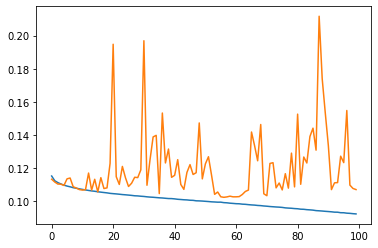

In [13]:
plt.plot(range(len(train_loss_history)), train_loss_history)
plt.plot(range(len(val_loss_history)), val_loss_history)

In [14]:
np.save("res_stage1_train_loss", np.array(train_loss_history))
np.save("res_stage1_val_loss", np.array(val_loss_history))

In [15]:
# train regression
PATH = "./100_res_model"

optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
num_epoch = 15
model = resUnet(in_channels=1, out_channels=2, classification=False).cuda()
model.load_state_dict(torch.load(PATH))


for epoch in range(num_epoch):
    epoch_start_time = time.time()
    iter_data_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0
    
    model.train() # 確保 model 是在 train model (開啟 Dropout 等...)
    for i, data in enumerate(tqdm(train_loader)):
        iter_start_time = time.time()
        # time to load data
        t_data = iter_start_time - iter_data_time

        # 確保歸零，不然會累積
        optimizer.zero_grad() # 用 optimizer 將 model 參數的 gradient 歸零
        pred_class, train_pred = model(data[0].cuda()) # 利用 model 得到預測的機率分佈 這邊實際上就是去呼叫 model 的 forward 函數
        #print(train_pred.size(), data[1].size())
        
        real_B_enc = encode_ab_ind(data[1][:, :, ::4, ::4])
        
        # 計算 loss （注意 prediction 跟 label 必須同時在 CPU 或是 GPU 上）
        loss_L1_reg = lossL1(train_pred.type(torch.cuda.FloatTensor), data[1].type(torch.cuda.FloatTensor).cuda())
        loss_CE = lossCE(pred_class.type(torch.cuda.FloatTensor), real_B_enc[:, 0, :, :].type(torch.cuda.LongTensor).cuda())
        # 自動 one-hot encoding
        batch_loss = loss_L1_reg + loss_CE
        batch_loss.backward() # 利用 back propagation 算出每個參數的 gradient
        optimizer.step() # 以 optimizer 用 gradient 更新參數值

        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()
    
    model.eval() #model 變成測試模式
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            pred_class, val_pred = model(data[0].cuda())
            #batch_loss = loss(val_pred, data[1].cuda())
            real_B_enc = encode_ab_ind(data[1][:, :, ::4, ::4])
            loss_L1_reg = lossL1(val_pred.type(torch.cuda.FloatTensor), data[1].type(torch.cuda.FloatTensor).cuda())
            loss_CE = lossCE(pred_class.type(torch.cuda.FloatTensor), real_B_enc[:, 0, :, :].type(torch.cuda.LongTensor).cuda())
            batch_loss = loss_L1_reg + loss_CE
            
            if(i == 1):
                L = data[0][6].cpu().numpy().transpose(1, 2, 0)
                realAB = data[1][6].cpu().numpy().transpose(1, 2, 0)
                predAB = val_pred[6].cpu().numpy().transpose(1, 2, 0)
                realImg = (np.concatenate((L, realAB), axis=2) * 255).astype(np.uint8)
                fakeImg = (np.concatenate((L, predAB), axis=2) * 255).astype(np.uint8)
                # opencv 用 datatype 判斷圖片
                realImg = cv2.cvtColor(realImg, cv2.COLOR_LAB2BGR)
                fakeImg = cv2.cvtColor(fakeImg, cv2.COLOR_LAB2BGR) 
                #print(realImg)
                #plt.imshow(realImg)
                #plt.show()
                cv2.imwrite(str(epoch + 1) + "_stage2_real" + ".png"  , realImg)
                cv2.imwrite(str(epoch + 1) + "_stage2_fake" + ".png"  , fakeImg)
            val_acc += np.sum(np.argmax(val_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            val_loss += batch_loss.item()
        
        # 只 save parameters (建議的方式)
        torch.save(model.state_dict(), str(epoch + 1) +  "_stage2_res_model")
        
        #if val_loss < best_val_loss:
        #    best_val_loss = val_loss
        #    torch.save(model, "best_model")
        #將結果 print 出來
        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f | time to load: %2.2f' % \
            (epoch + 1, num_epoch, time.time()-epoch_start_time, \
             train_acc/train_set.__len__(), train_loss/train_set.__len__(), val_acc/val_set.__len__(), val_loss/val_set.__len__(), t_data))
        
        train_loss_history.append(train_loss/train_set.__len__())
        val_loss_history.append(val_loss/val_set.__len__())

100%|██████████████████████████████████████████████████████████████████████████████| 4167/4167 [33:15<00:00,  2.09it/s]
C:\Users\USER\Miniconda3\envs\testJ\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[001/100] 2032.91 sec(s) Train Acc: 0.000000 Loss: 0.091295 | Val Acc: 0.000000 loss: 0.105469 | time to load: 1995.24


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[002/100] 2015.20 sec(s) Train Acc: 0.000000 Loss: 0.091282 | Val Acc: 0.000000 loss: 0.106860 | time to load: 1977.73


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[003/100] 2015.00 sec(s) Train Acc: 0.000000 Loss: 0.091265 | Val Acc: 0.000000 loss: 0.106307 | time to load: 1977.57


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[004/100] 2015.74 sec(s) Train Acc: 0.000000 Loss: 0.091280 | Val Acc: 0.000000 loss: 0.107763 | time to load: 1978.13


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[005/100] 2016.46 sec(s) Train Acc: 0.000000 Loss: 0.091279 | Val Acc: 0.000000 loss: 0.105925 | time to load: 1978.83


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[006/100] 2017.55 sec(s) Train Acc: 0.000000 Loss: 0.091275 | Val Acc: 0.000000 loss: 0.107909 | time to load: 1979.77


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[007/100] 2021.18 sec(s) Train Acc: 0.000000 Loss: 0.091246 | Val Acc: 0.000000 loss: 0.105513 | time to load: 1983.34


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[008/100] 2021.48 sec(s) Train Acc: 0.000000 Loss: 0.091269 | Val Acc: 0.000000 loss: 0.108815 | time to load: 1983.73


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[009/100] 2021.75 sec(s) Train Acc: 0.000000 Loss: 0.091247 | Val Acc: 0.000000 loss: 0.107739 | time to load: 1984.03


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[010/100] 2021.01 sec(s) Train Acc: 0.000000 Loss: 0.091290 | Val Acc: 0.000000 loss: 0.106756 | time to load: 1983.40


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[011/100] 2021.85 sec(s) Train Acc: 0.000000 Loss: 0.091284 | Val Acc: 0.000000 loss: 0.108760 | time to load: 1984.15


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[012/100] 2021.96 sec(s) Train Acc: 0.000000 Loss: 0.091268 | Val Acc: 0.000000 loss: 0.105160 | time to load: 1984.27


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[013/100] 2021.59 sec(s) Train Acc: 0.000000 Loss: 0.091210 | Val Acc: 0.000000 loss: 0.105540 | time to load: 1983.91


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[014/100] 2022.44 sec(s) Train Acc: 0.000000 Loss: 0.091251 | Val Acc: 0.000000 loss: 0.106034 | time to load: 1984.91


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[015/100] 2022.93 sec(s) Train Acc: 0.000000 Loss: 0.091275 | Val Acc: 0.000000 loss: 0.108808 | time to load: 1985.37


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[016/100] 2021.84 sec(s) Train Acc: 0.000000 Loss: 0.091264 | Val Acc: 0.000000 loss: 0.106422 | time to load: 1984.28


 55%|██████████████████████████████████████████▊                                   | 2287/4167 [18:11<14:57,  2.09it/s]


KeyboardInterrupt: 

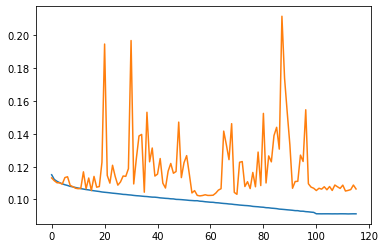

In [16]:
plt.plot(range(len(train_loss_history)), train_loss_history)
plt.plot(range(len(val_loss_history)), val_loss_history)

In [19]:
np.save("./stage2/res_stage2_train_loss", np.array(train_loss_history))
np.save("./stage2/res_stage2_val_loss", np.array(val_loss_history))

In [15]:
"""
    stage 3
"""
train_loss_history = list(np.load('./stage2/res_stage2_train_loss.npy')) #back to list
val_loss_history = list(np.load('./stage2/res_stage2_val_loss.npy'))

In [16]:
# train regression
localPath = "./stage3/"
PATH = "./stage2/16_stage2_res_model"

# lr = 1e-6
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
num_epoch = 5
model = resUnet(in_channels=1, out_channels=2, classification=False).cuda()
model.load_state_dict(torch.load(PATH))


for epoch in range(num_epoch):
    epoch_start_time = time.time()
    iter_data_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0
    
    model.train() # 確保 model 是在 train model (開啟 Dropout 等...)
    for i, data in enumerate(tqdm(train_loader)):
        iter_start_time = time.time()
        # time to load data
        t_data = iter_start_time - iter_data_time

        # 確保歸零，不然會累積
        optimizer.zero_grad() # 用 optimizer 將 model 參數的 gradient 歸零
        pred_class, train_pred = model(data[0].cuda()) # 利用 model 得到預測的機率分佈 這邊實際上就是去呼叫 model 的 forward 函數
        #print(train_pred.size(), data[1].size())
        
        real_B_enc = encode_ab_ind(data[1][:, :, ::4, ::4])
        
        # 計算 loss （注意 prediction 跟 label 必須同時在 CPU 或是 GPU 上）
        loss_L1_reg = lossL1(train_pred.type(torch.cuda.FloatTensor), data[1].type(torch.cuda.FloatTensor).cuda())
        loss_CE = lossCE(pred_class.type(torch.cuda.FloatTensor), real_B_enc[:, 0, :, :].type(torch.cuda.LongTensor).cuda())
        # 自動 one-hot encoding
        batch_loss = loss_L1_reg + loss_CE
        batch_loss.backward() # 利用 back propagation 算出每個參數的 gradient
        optimizer.step() # 以 optimizer 用 gradient 更新參數值

        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()
    
    model.eval() #model 變成測試模式
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            pred_class, val_pred = model(data[0].cuda())
            #batch_loss = loss(val_pred, data[1].cuda())
            real_B_enc = encode_ab_ind(data[1][:, :, ::4, ::4])
            loss_L1_reg = lossL1(val_pred.type(torch.cuda.FloatTensor), data[1].type(torch.cuda.FloatTensor).cuda())
            loss_CE = lossCE(pred_class.type(torch.cuda.FloatTensor), real_B_enc[:, 0, :, :].type(torch.cuda.LongTensor).cuda())
            batch_loss = loss_L1_reg + loss_CE
            
            if(i == 1):
                L = data[0][6].cpu().numpy().transpose(1, 2, 0)
                realAB = data[1][6].cpu().numpy().transpose(1, 2, 0)
                predAB = val_pred[6].cpu().numpy().transpose(1, 2, 0)
                realImg = (np.concatenate((L, realAB), axis=2) * 255).astype(np.uint8)
                fakeImg = (np.concatenate((L, predAB), axis=2) * 255).astype(np.uint8)
                # opencv 用 datatype 判斷圖片
                realImg = cv2.cvtColor(realImg, cv2.COLOR_LAB2BGR)
                fakeImg = cv2.cvtColor(fakeImg, cv2.COLOR_LAB2BGR) 
                #print(realImg)
                #plt.imshow(realImg)
                #plt.show()
                cv2.imwrite(localPath + str(epoch + 1) + "_stage3_real" + ".png"  , realImg)
                cv2.imwrite(localPath + str(epoch + 1) + "_stage3_fake" + ".png"  , fakeImg)
            val_acc += np.sum(np.argmax(val_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            val_loss += batch_loss.item()
        
        # 只 save parameters (建議的方式)
        torch.save(model.state_dict(), localPath + str(epoch + 1) +  "_stage3_res_model")
        
        #if val_loss < best_val_loss:
        #    best_val_loss = val_loss
        #    torch.save(model, "best_model")
        #將結果 print 出來
        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f | time to load: %2.2f' % \
            (epoch + 1, num_epoch, time.time()-epoch_start_time, \
             train_acc/train_set.__len__(), train_loss/train_set.__len__(), val_acc/val_set.__len__(), val_loss/val_set.__len__(), t_data))
        
        train_loss_history.append(train_loss/train_set.__len__())
        val_loss_history.append(val_loss/val_set.__len__())

100%|██████████████████████████████████████████████████████████████████████████████| 4167/4167 [33:12<00:00,  2.09it/s]
C:\Users\USER\Miniconda3\envs\testJ\lib\site-packages\ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[001/005] 2029.85 sec(s) Train Acc: 0.000000 Loss: 0.091222 | Val Acc: 0.000000 loss: 0.106256 | time to load: 1991.97


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[002/005] 2136.09 sec(s) Train Acc: 0.000000 Loss: 0.091295 | Val Acc: 0.000000 loss: 0.106511 | time to load: 2095.25


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[003/005] 2189.87 sec(s) Train Acc: 0.000000 Loss: 0.091208 | Val Acc: 0.000000 loss: 0.107181 | time to load: 2149.17


  0%|                                                                                         | 0/4167 [00:00<?, ?it/s]

[004/005] 2191.16 sec(s) Train Acc: 0.000000 Loss: 0.091231 | Val Acc: 0.000000 loss: 0.108392 | time to load: 2150.40


100%|██████████████████████████████████████████████████████████████████████████████| 4167/4167 [35:51<00:00,  1.94it/s]


[005/005] 2191.90 sec(s) Train Acc: 0.000000 Loss: 0.091285 | Val Acc: 0.000000 loss: 0.108271 | time to load: 2151.10


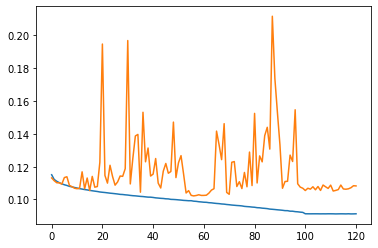

In [17]:
plt.plot(range(len(train_loss_history)), train_loss_history)
plt.plot(range(len(val_loss_history)), val_loss_history)

In [23]:
model.load_state_dict(torch.load("./stage1/60_res_model"))

model.eval() #model 變成測試模式
#localPath = "./result/"
localPath = "./result2/"
indexCount = 0


class valDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.x = x
        # label is required to be a LongTensor
        self.y = y

        self.transform = transform
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        X = self.x[index]
        Y = self.y[index]
        if self.transform is not None:
            X = self.transform(X)
            Y = self.transform(Y)
        return X, Y

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

val_set = valDataset(val_x, val_y, val_transform)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

with torch.no_grad():
    for i, data in enumerate(val_loader):
        pred_class, val_pred = model(data[0].cuda())

        for j in range(batch_size):
            L = data[0][j].cpu().numpy().transpose(1, 2, 0)
            predAB = val_pred[j].cpu().numpy().transpose(1, 2, 0)
            fakeImg = (np.concatenate((L, predAB), axis=2) * 255).astype(np.uint8)
            # opencv 用 datatype 判斷圖片
            fakeImg = cv2.cvtColor(fakeImg, cv2.COLOR_LAB2BGR) 
            #print(realImg)
            #plt.imshow(realImg)
            #plt.show()
            cv2.imwrite(localPath + str(indexCount + 1) + ".png"  , fakeImg)
            indexCount += 1

IndexError: index 8 is out of bounds for dimension 0 with size 8

In [15]:
#model.load_state_dict(torch.load("./stage3/5_stage3_res_model"))
model.load_state_dict(torch.load("./stage1/60_res_model"))

model.eval() #model 變成測試模式
localPath = "./test2/"
indexCount = 0
batch_size = 32

class valDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.x = x
        # label is required to be a LongTensor
        self.y = y

        self.transform = transform
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        X = self.x[index]
        Y = self.y[index]
        if self.transform is not None:
            X = self.transform(X)
            Y = self.transform(Y)
        return X, Y

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

val_set = valDataset( test_x ,  test_y , val_transform)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

with torch.no_grad():
    for i, data in enumerate(val_loader):
        pred_class, val_pred = model(data[0].cuda())

        for j in range(batch_size):
            L = data[0][j].cpu().numpy().transpose(1, 2, 0)
            predAB = val_pred[j].cpu().numpy().transpose(1, 2, 0)
            fakeImg = (np.concatenate((L, predAB), axis=2) * 255).astype(np.uint8)
            # opencv 用 datatype 判斷圖片
            fakeImg = cv2.cvtColor(fakeImg, cv2.COLOR_LAB2BGR) 
            #print(realImg)
            #plt.imshow(realImg)
            #plt.show()
            cv2.imwrite(localPath + str(indexCount + 1) + ".png"  , fakeImg)
            indexCount += 1

IndexError: index 8 is out of bounds for dimension 0 with size 8

In [11]:
"""
    Final Result
"""
def readPredResult(path, imgRow=256, imgCol=256):
    # label 是 csv file 在 ./ 下的名稱，有提供則回傳 y
    image_dir = sorted(os.listdir(path), key=lambda x:int(x[:-4]))
    #print(image_dir[:20])
    i = 0
    predResult = np.zeros((len(image_dir), imgRow, imgCol, 3), dtype=np.uint8)
    
    for file in tqdm(image_dir):
        img = cv2.imread(os.path.join(path, file))
        predResult[i, :, :, :] = img
        i += 1
            
    return predResult

In [12]:
# calculate psnr
# https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio
fakeImgPath = "./result/"
print("read pred img")
fakeImgs = readPredResult(path=fakeImgPath, imgRow=val_x[0].shape[0], imgCol=val_x[0].shape[1])

print("caculate PSNR")
resultPsnr = 0.
length = len(val_x)
for i in tqdm( range(length) ):
    realImg = (np.concatenate((val_x[i], val_y[i]), axis=2)).astype(np.uint8)
    realImg = cv2.cvtColor(realImg, cv2.COLOR_LAB2BGR) 
    resultPsnr += calculate_psnr_np(fakeImgs[i], realImg)

print(resultPsnr / length)

  1%|▉                                                                              | 59/5000 [00:00<00:08, 579.98it/s]

read pred img


  1%|▉                                                                              | 63/5000 [00:00<00:16, 307.62it/s]

caculate PSNR


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:16<00:00, 307.51it/s]

23.5841895786079


In [13]:
fakeImgPath = "./result2/"
print("read pred img")
fakeImgs = readPredResult(path=fakeImgPath, imgRow=val_x[0].shape[0], imgCol=val_x[0].shape[1])

print("caculate PSNR")
resultPsnr = 0.
length = len(val_x)
for i in tqdm( range(length) ):
    realImg = (np.concatenate((val_x[i], val_y[i]), axis=2)).astype(np.uint8)
    realImg = cv2.cvtColor(realImg, cv2.COLOR_LAB2BGR) 
    resultPsnr += calculate_psnr_np(fakeImgs[i], realImg)

print(resultPsnr / length)

  1%|▉                                                                              | 59/5000 [00:00<00:08, 585.72it/s]

read pred img


  1%|▍                                                                              | 28/5000 [00:00<00:18, 272.57it/s]

caculate PSNR


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:15<00:00, 313.63it/s]

23.872329923483708


In [14]:
# calculate psnr
# https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio
fakeImgPath = "./test/"
print("read pred img")
fakeImgs = readPredResult(path=fakeImgPath, imgRow=val_x[0].shape[0], imgCol=val_x[0].shape[1])

print("caculate PSNR")
resultPsnr = 0.
length = len(val_x)
for i in tqdm( range(length) ):
    realImg = (np.concatenate((test_x[i], test_y[i]), axis=2)).astype(np.uint8)
    realImg = cv2.cvtColor(realImg, cv2.COLOR_LAB2BGR) 
    resultPsnr += calculate_psnr_np(fakeImgs[i], realImg)

print(resultPsnr / length)

  1%|▊                                                                              | 48/5000 [00:00<00:10, 479.27it/s]

read pred img


  1%|▉                                                                              | 56/5000 [00:00<00:18, 272.91it/s]

caculate PSNR


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:16<00:00, 312.49it/s]

23.628412153260726


In [16]:
# calculate psnr
# https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio
fakeImgPath = "./test2/"
print("read pred img")
fakeImgs = readPredResult(path=fakeImgPath, imgRow=val_x[0].shape[0], imgCol=val_x[0].shape[1])

print("caculate PSNR")
resultPsnr = 0.
length = len(val_x)
for i in tqdm( range(length) ):
    realImg = (np.concatenate((test_x[i], test_y[i]), axis=2)).astype(np.uint8)
    realImg = cv2.cvtColor(realImg, cv2.COLOR_LAB2BGR) 
    resultPsnr += calculate_psnr_np(fakeImgs[i], realImg)

print(resultPsnr / length)

  1%|▋                                                                              | 43/5000 [00:00<00:11, 427.50it/s]

read pred img


  1%|▉                                                                              | 59/5000 [00:00<00:17, 280.65it/s]

caculate PSNR


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:15<00:00, 317.51it/s]

23.9765140914666
